In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'NOK=X'
numbers_in_currency = 'USD'
share_name = 'DNO.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-12-31,80,-82,-2,-252,114,187,78,379,0,...,0,0,0,219,215,569,10,-63,1010.2,2015-02-19
1,2015-03-31,26,-62,-36,-74,204,175,63,442,0,...,0,0,0,236,209,572,6,-35,1069.5,2015-05-05
2,2015-06-30,55,-66,-11,-40,450,188,69,707,0,...,0,0,181,380,345,850,-52,-13,1069.5,2015-08-04
3,2015-09-30,52,-43,9,-15,247,180,71,498,0,...,0,0,0,152,348,625,-22,-1,1069.5,2015-11-04
4,2015-12-31,55,-27,28,-83,238,156,62,455,0,...,0,0,0,124,351,572,-6,-1,1069.5,2016-02-19


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-12-31,2024-02-19,975.0,199,-116,84,4,719,265,78,...,202,2638,221,0,166,415,392,1404,102,-36
37,2024-03-31,2024-05-06,975.0,182,-107,75,17,606,249,76,...,208,2471,191,0,35,271,393,1257,94,-36
38,2024-06-30,2024-08-12,975.0,137,-79,58,34,943,269,71,...,220,2954,257,0,0,322,773,1724,136,-52
39,2024-09-30,2024-11-04,975.0,170,-102,68,20,919,291,77,...,224,3052,291,0,0,340,774,1830,104,-75
40,2024-12-31,2025-02-05,975.0,176,-119,57,-98,899,338,75,...,229,2966,324,0,0,354,791,1886,82,-63


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-12-31,2024-02-19,975.0,199,-116,84,4,719,265,78,...,2638,221,0,166,415,392,1404,102,-36,10.821103
37,2024-03-31,2024-05-06,975.0,182,-107,75,17,606,249,76,...,2471,191,0,35,271,393,1257,94,-36,10.502364
38,2024-06-30,2024-08-12,975.0,137,-79,58,34,943,269,71,...,2954,257,0,0,322,773,1724,136,-52,10.750878
39,2024-09-30,2024-11-04,975.0,170,-102,68,20,919,291,77,...,3052,291,0,0,340,774,1830,104,-75,10.704589
40,2024-12-31,2025-02-05,975.0,176,-119,57,-98,899,338,75,...,2966,324,0,0,354,791,1886,82,-63,11.019793


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-12-31,2024-02-19,975.0,2153.399487,-1255.247942,908.972648,43.284412,7780.373021,2867.592282,844.046030,...,28546.069580,2391.463752,0.0,1796.303090,4490.757724,4241.872356,15192.828541,1103.752501,-389.559706,10.821103
37,2024-03-31,2024-05-06,975.0,1911.430223,-1123.752934,787.677290,178.540186,6364.432502,2615.088602,798.179654,...,25951.341111,2005.951498,0.0,367.582735,2846.140607,4127.428999,13201.471379,987.222203,-378.085099,10.502364
38,2024-06-30,2024-08-12,975.0,1472.870284,-849.319361,623.550923,365.529851,10138.077937,2891.986177,763.312337,...,31758.093559,2762.975641,0.0,0.000000,3461.782710,8310.428680,18534.513641,1462.119406,-559.045655,10.750878
39,2024-09-30,2024-11-04,975.0,1819.780081,-1091.868049,727.912032,214.091774,9837.517026,3115.035315,824.253331,...,32670.404747,3115.035315,0.0,0.000000,3639.560162,8285.351663,19589.397342,1113.277226,-802.844153,10.704589
40,2024-12-31,2025-02-05,975.0,1939.483556,-1311.355359,628.128197,-1079.939707,9906.793843,3724.690010,826.484470,...,32684.705828,3570.412909,0.0,0.000000,3901.006697,8716.656207,20783.329465,903.623020,-694.246955,11.019793


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2015-02-23,10.668900,2014-12-31,550.148862,0.0,3.62155,1010.2,0.0,0.0,783.962128,...,0.483197,0.516803,0.0,0.0,0.0,0.0,-0.025,-3.15,0.0,0.0
1,2015-03-02,10.583436,2014-12-31,550.148862,0.0,3.62155,1010.2,0.0,0.0,783.962128,...,0.483197,0.516803,0.0,0.0,0.0,0.0,-0.025,-3.15,0.0,0.0
2,2015-03-09,8.382709,2014-12-31,550.148862,0.0,3.62155,1010.2,0.0,0.0,783.962128,...,0.483197,0.516803,0.0,0.0,0.0,0.0,-0.025,-3.15,0.0,0.0
3,2015-03-16,9.045063,2014-12-31,550.148862,0.0,3.62155,1010.2,0.0,0.0,783.962128,...,0.483197,0.516803,0.0,0.0,0.0,0.0,-0.025,-3.15,0.0,0.0
4,2015-03-23,8.069334,2014-12-31,550.148862,0.0,3.62155,1010.2,0.0,0.0,783.962128,...,0.483197,0.516803,0.0,0.0,0.0,0.0,-0.025,-3.15,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2015-02-23,10.668900,2014-12-31,550.148862,0.0,3.62155,1010.2,0.0,0.0,783.962128,...,0.0,-0.025,-3.15,0.0,0.0,inf,2.945949,inf,inf,inf
1,2015-03-02,10.583436,2014-12-31,550.148862,0.0,3.62155,1010.2,0.0,0.0,783.962128,...,0.0,-0.025,-3.15,0.0,0.0,inf,2.922350,inf,inf,inf
2,2015-03-09,8.382709,2014-12-31,550.148862,0.0,3.62155,1010.2,0.0,0.0,783.962128,...,0.0,-0.025,-3.15,0.0,0.0,inf,2.314674,inf,inf,inf
3,2015-03-16,9.045063,2014-12-31,550.148862,0.0,3.62155,1010.2,0.0,0.0,783.962128,...,0.0,-0.025,-3.15,0.0,0.0,inf,2.497567,inf,inf,inf
4,2015-03-23,8.069334,2014-12-31,550.148862,0.0,3.62155,1010.2,0.0,0.0,783.962128,...,0.0,-0.025,-3.15,0.0,0.0,inf,2.228144,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

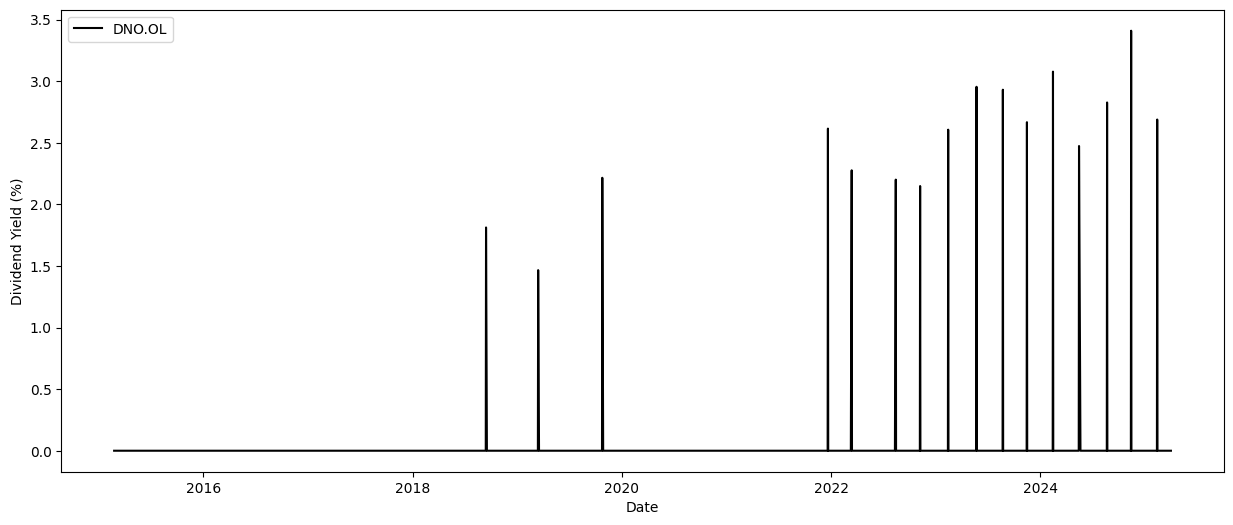

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.250751
share_price      1.000000
Name: share_price, dtype: float64


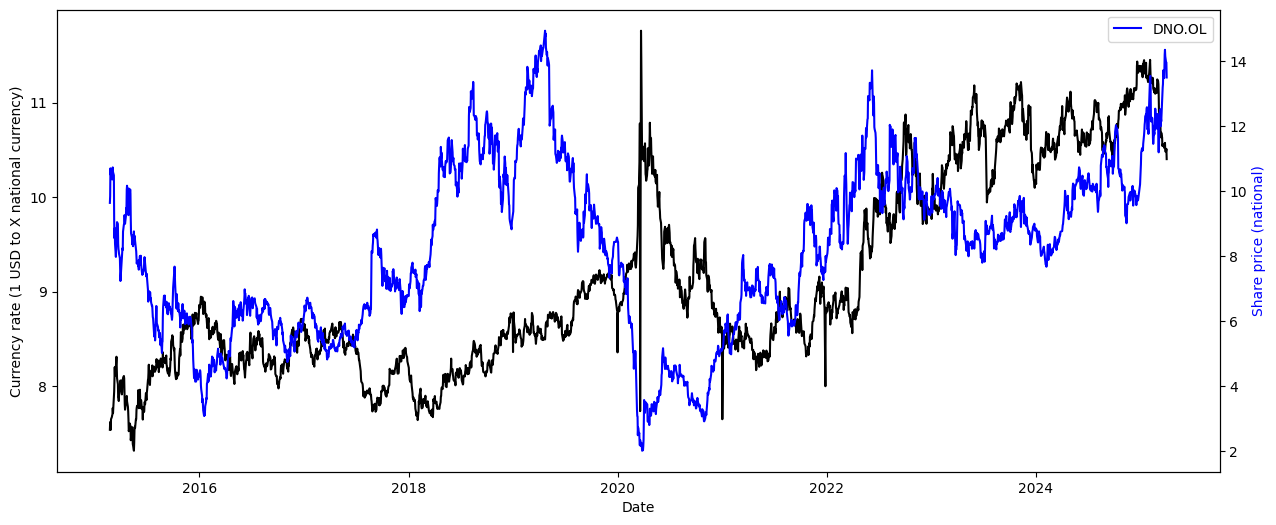

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

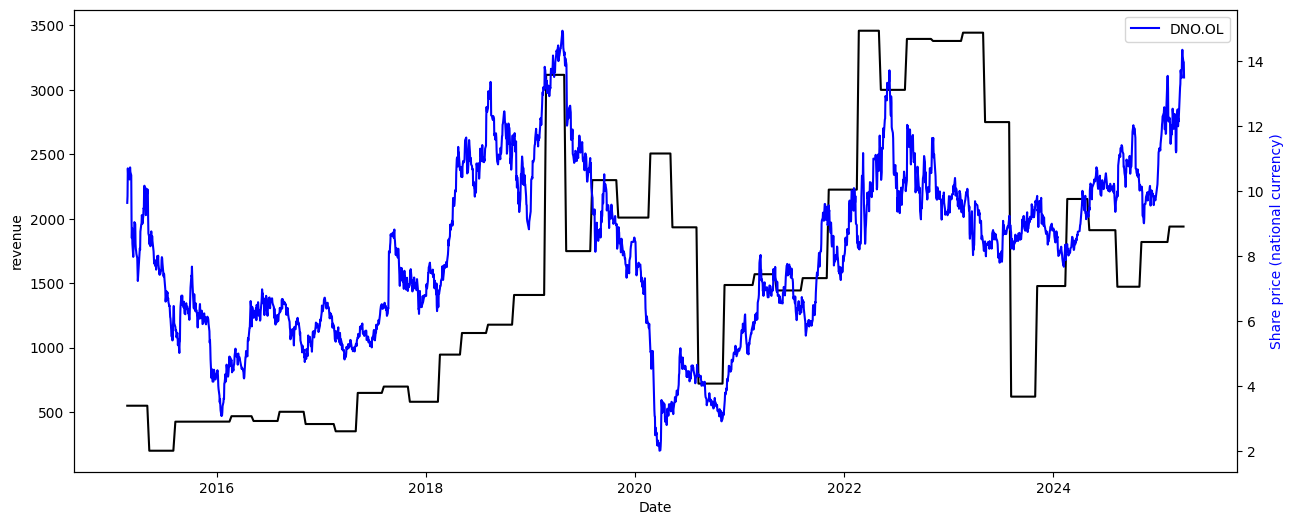

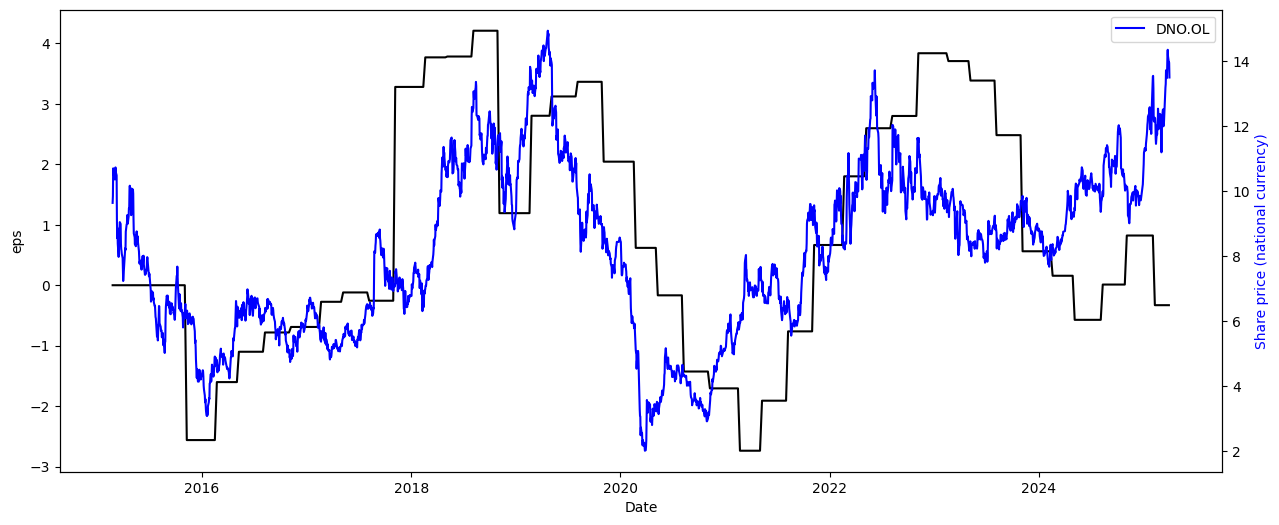

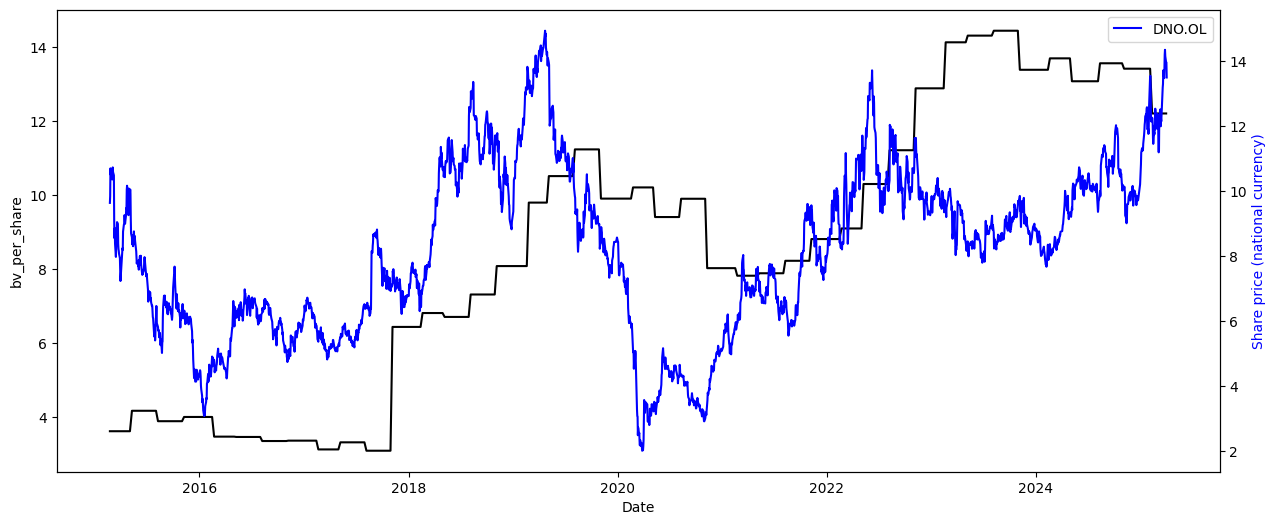

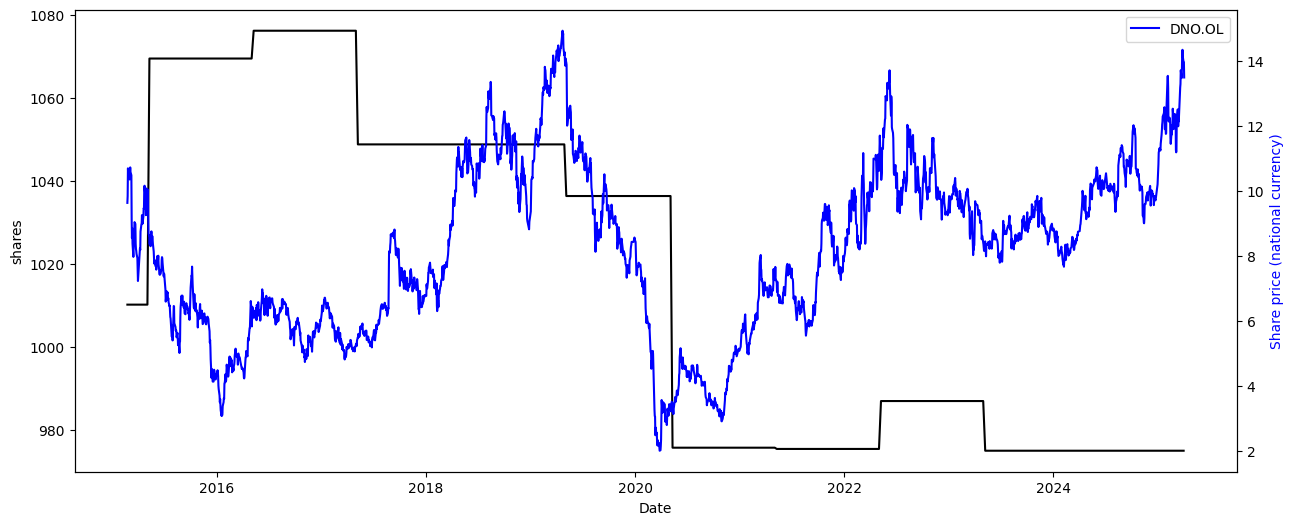

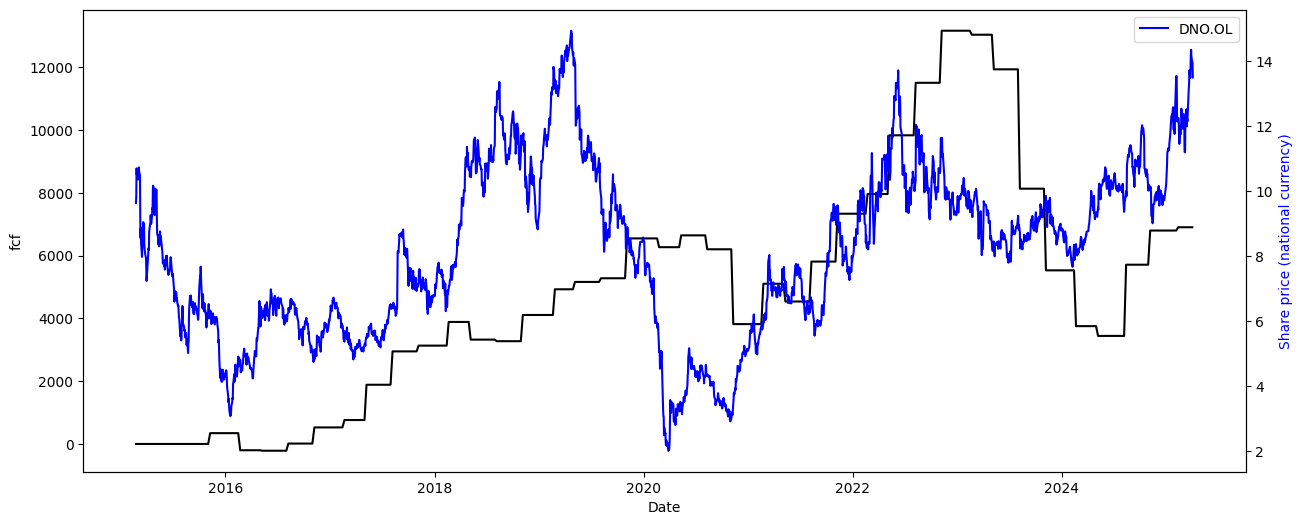

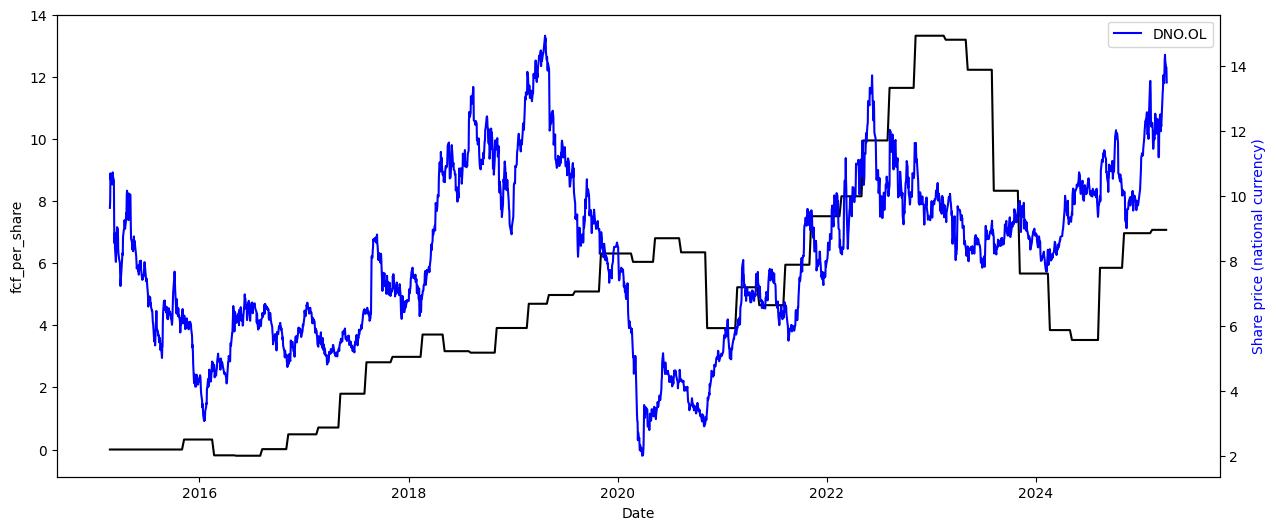

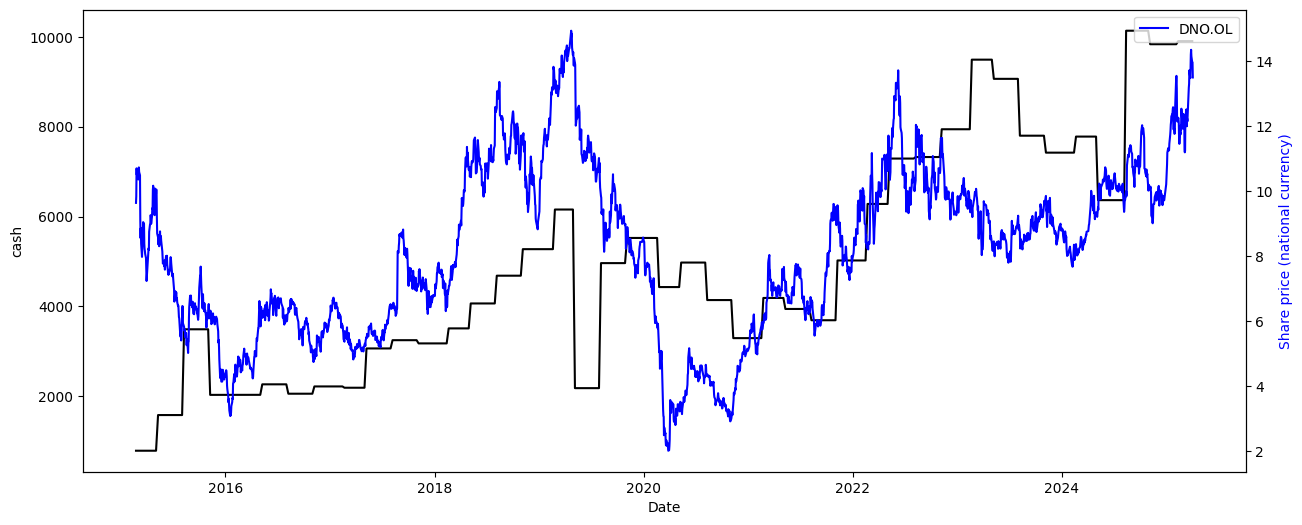

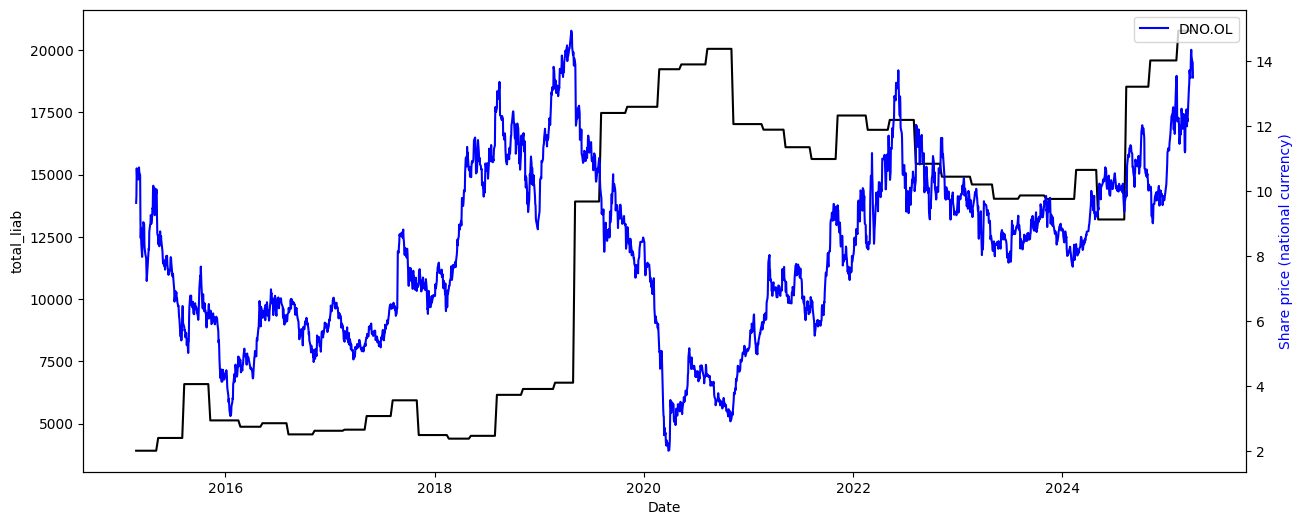

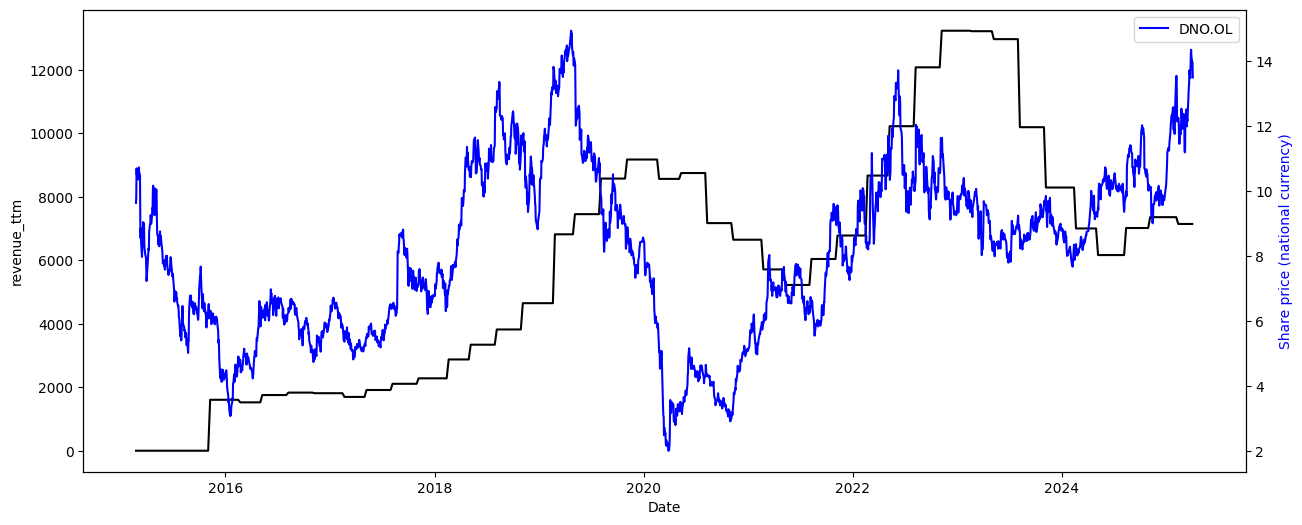

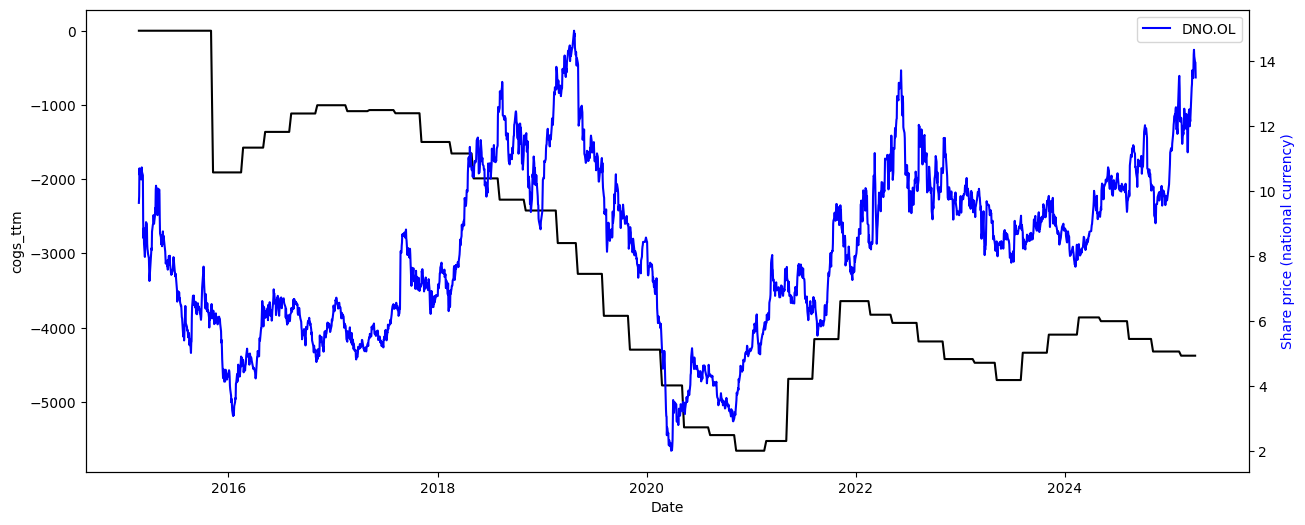

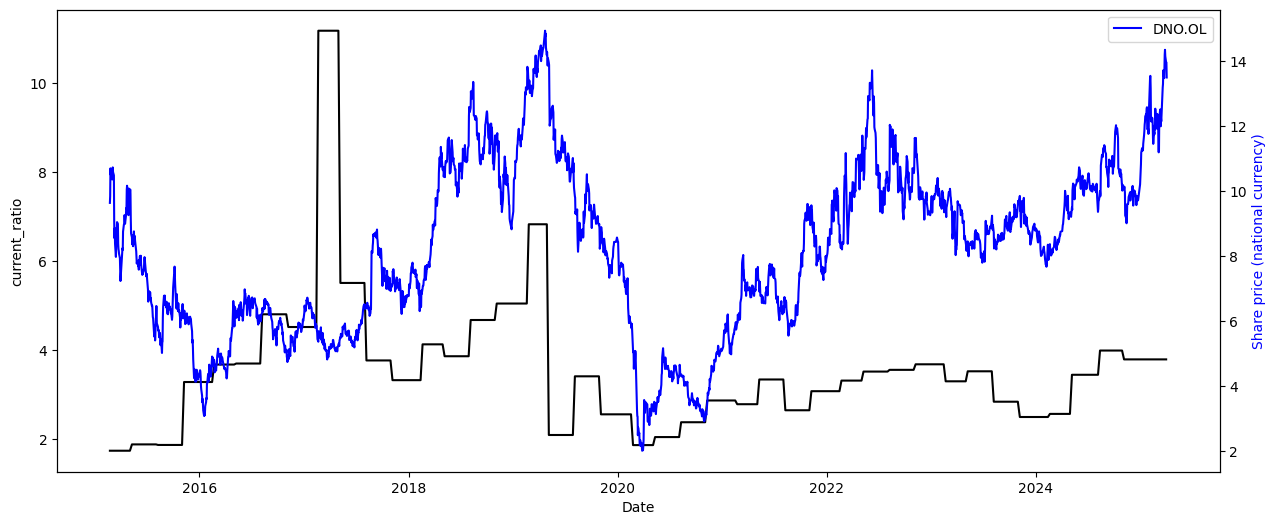

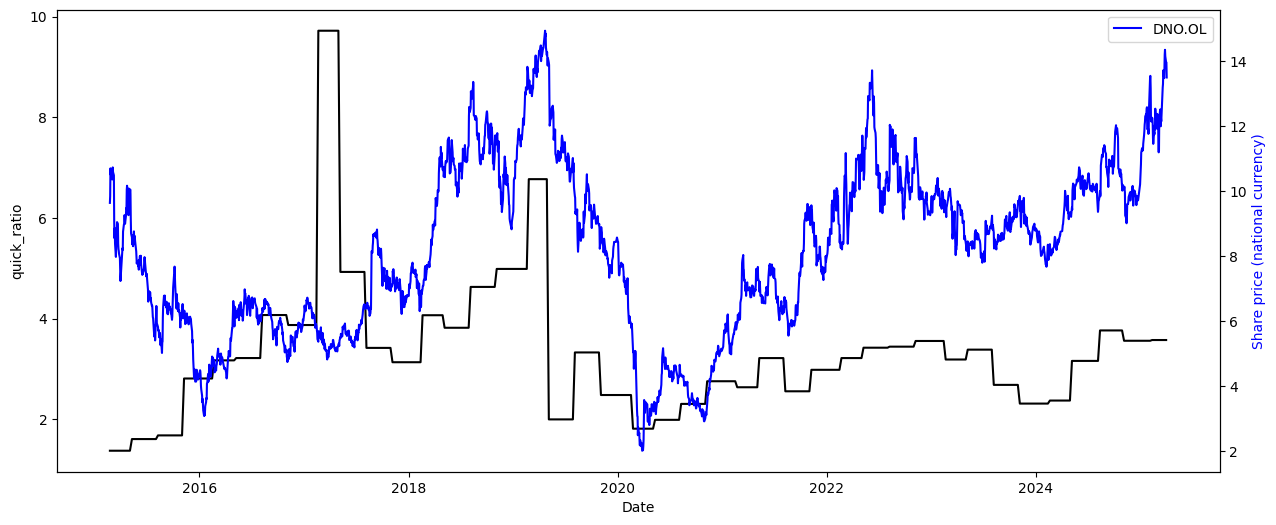

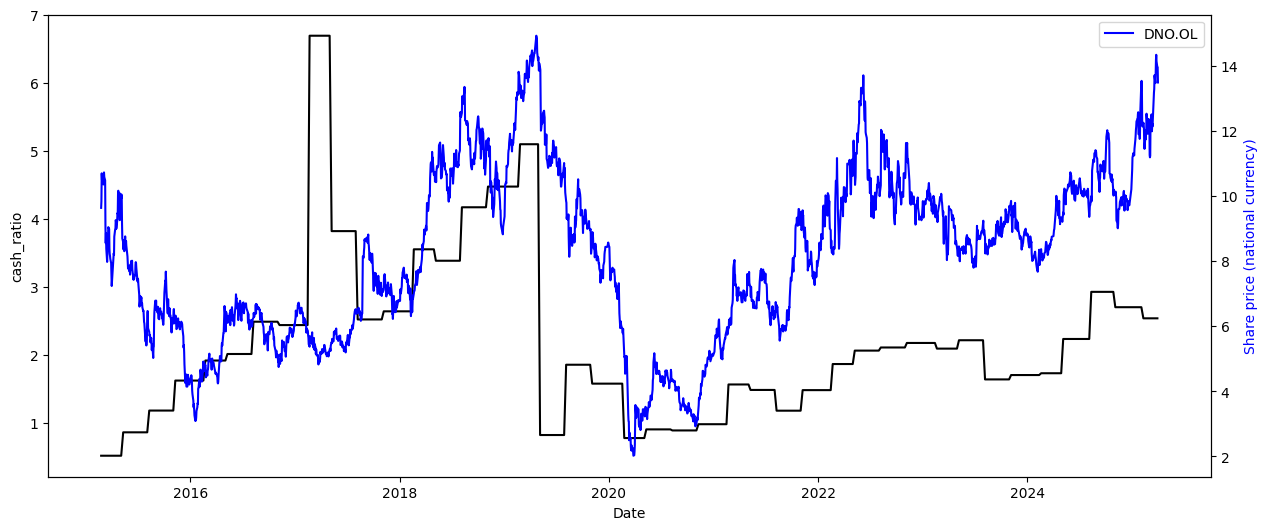

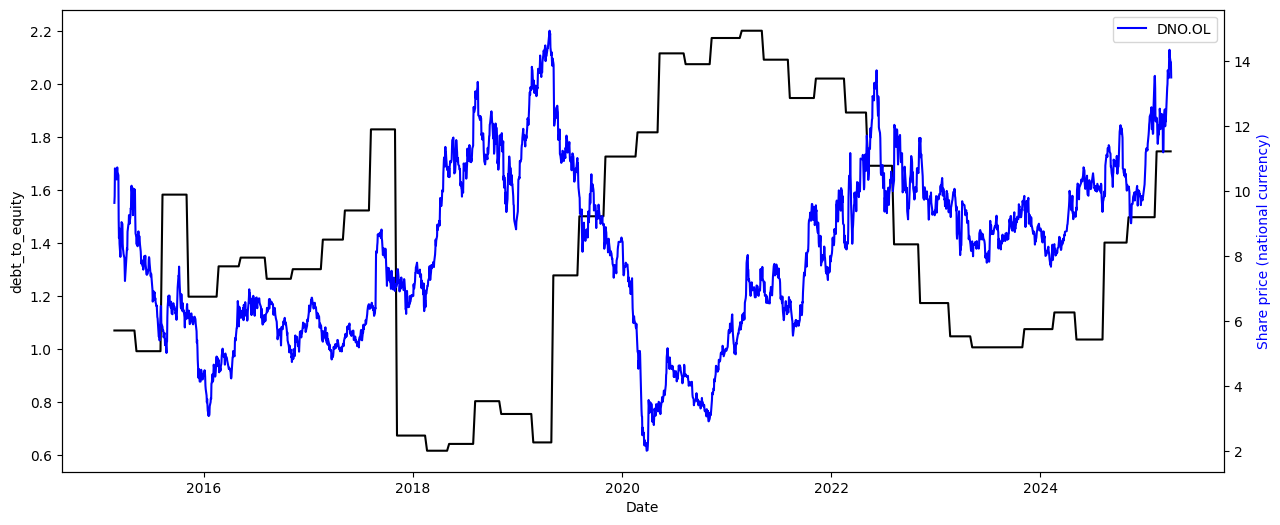

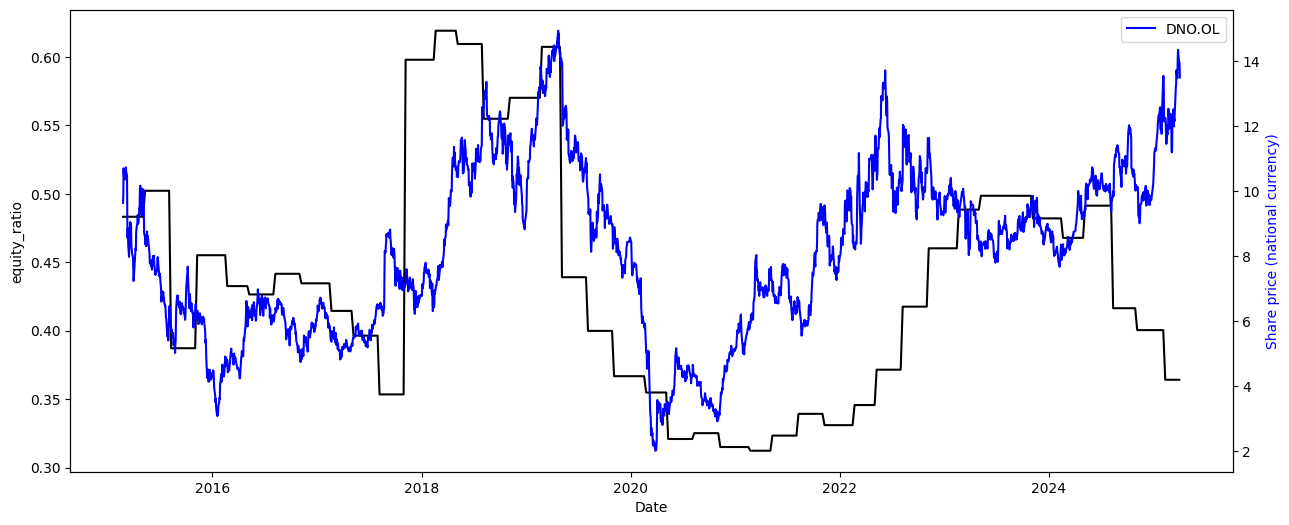

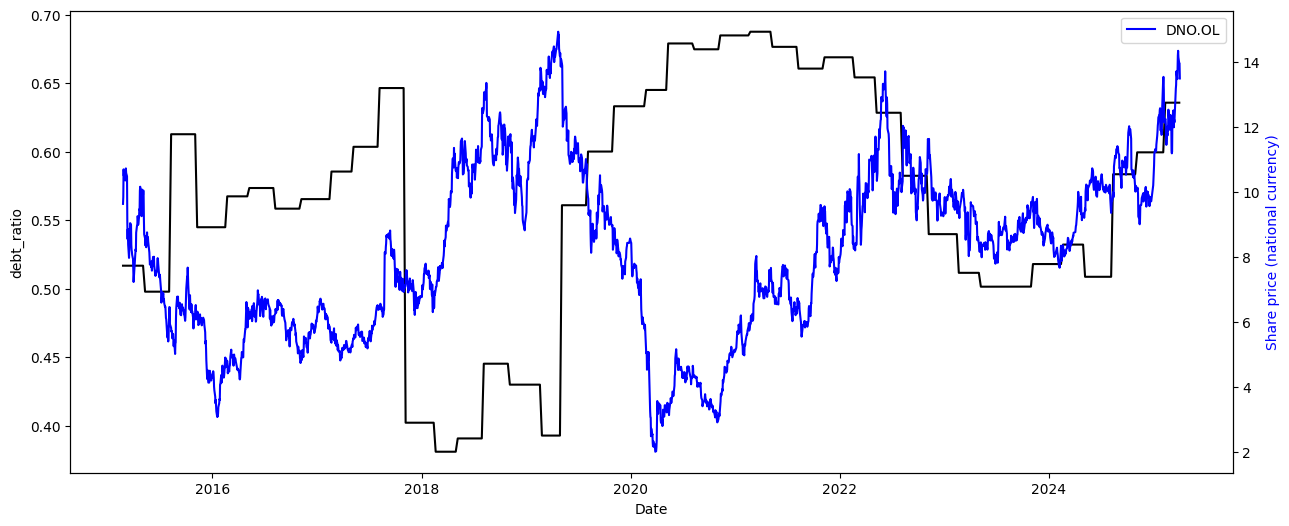

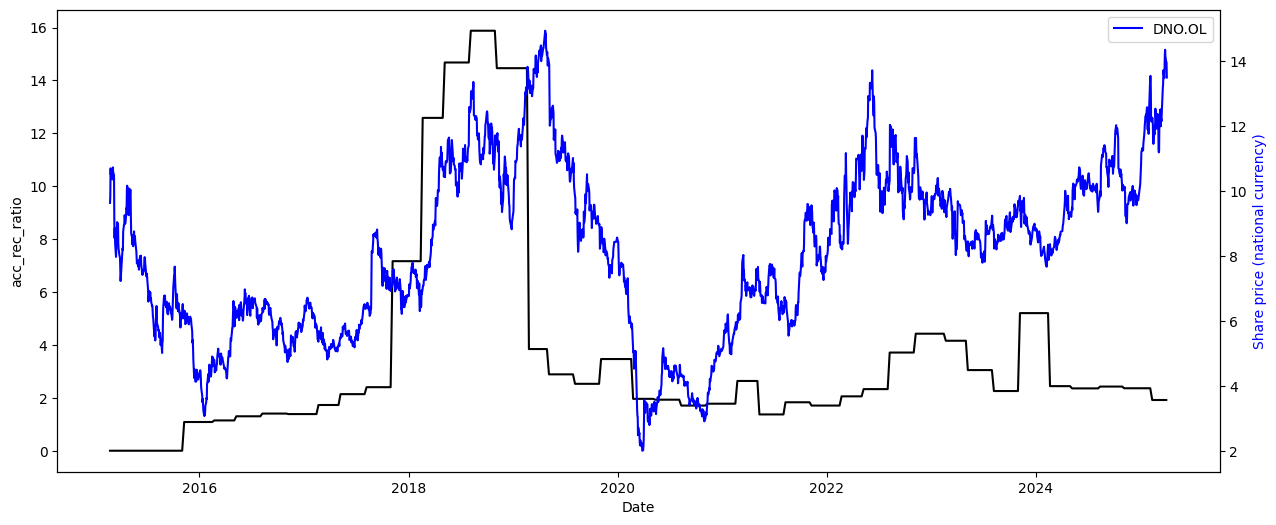

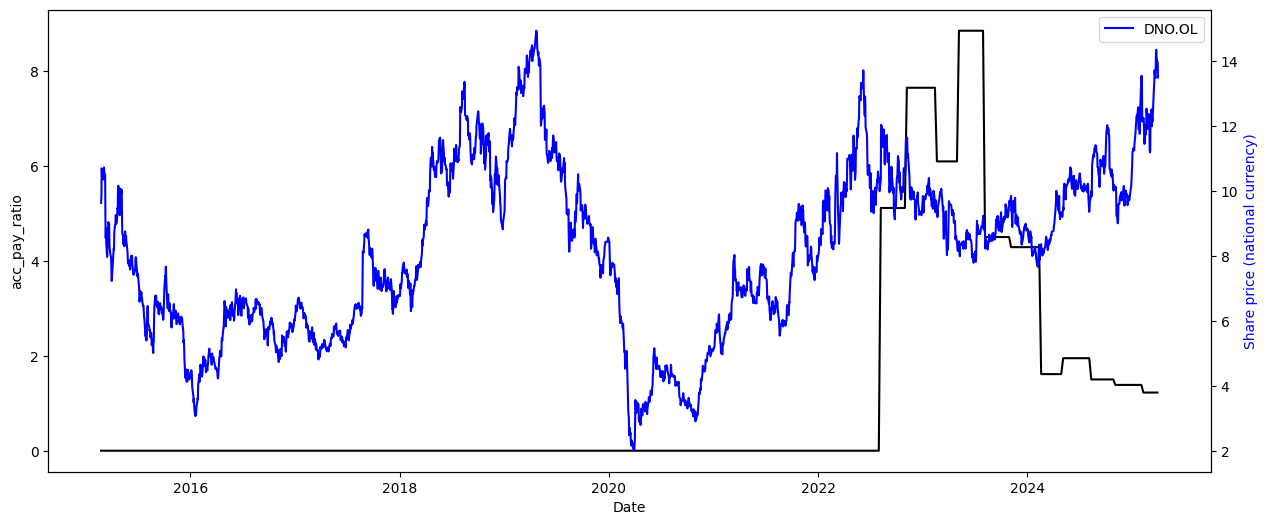

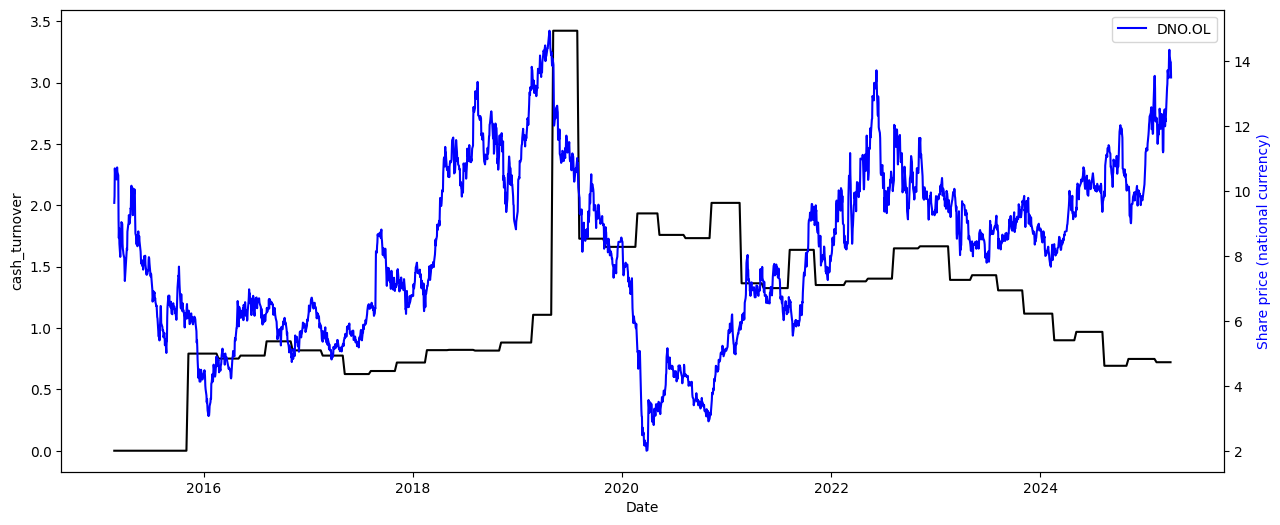

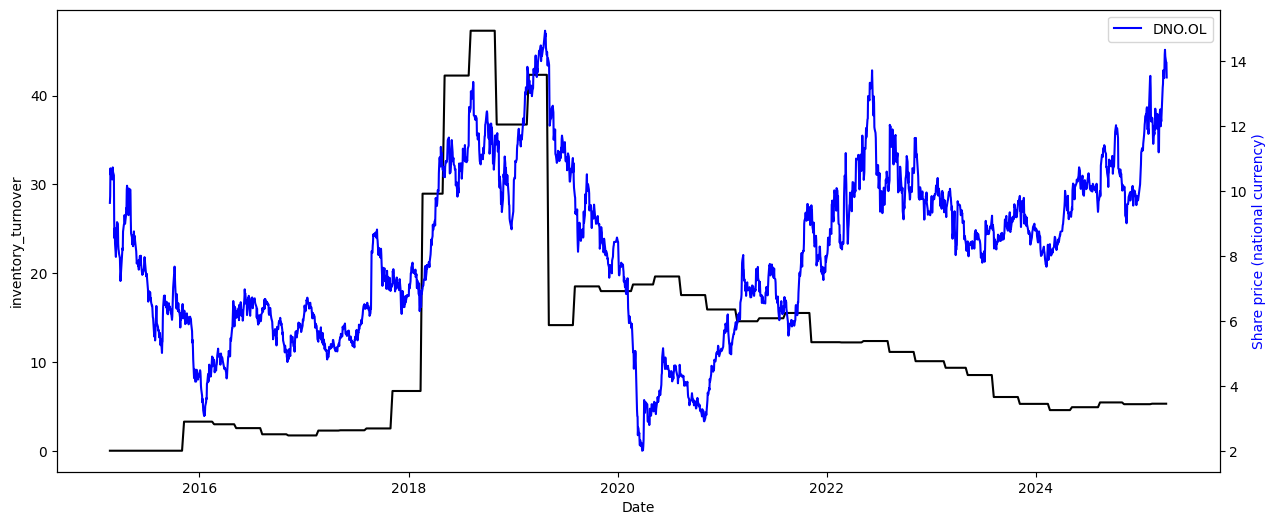

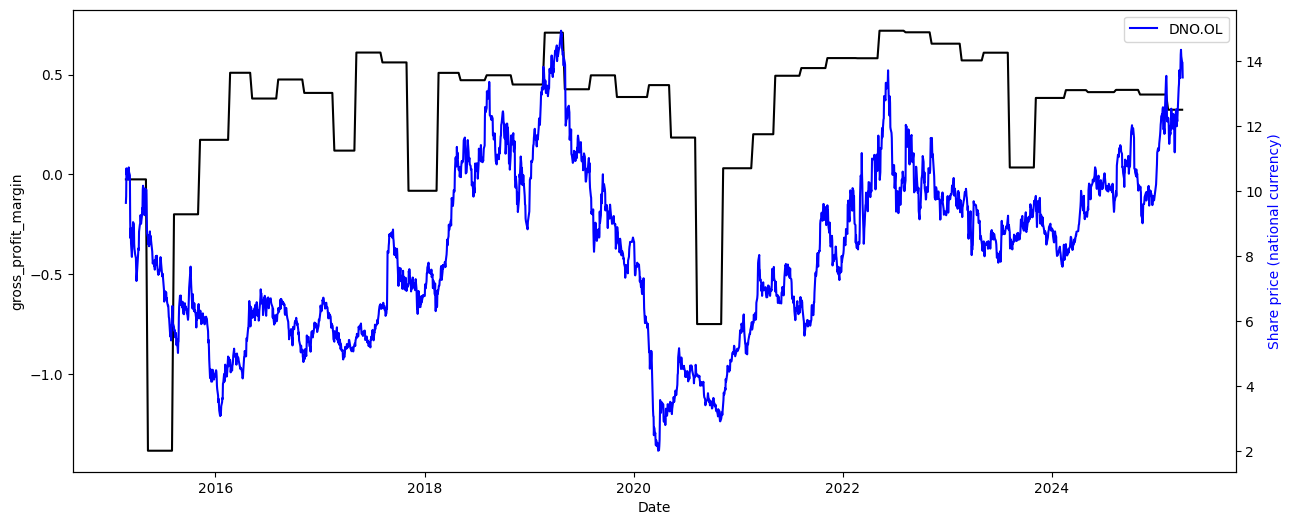

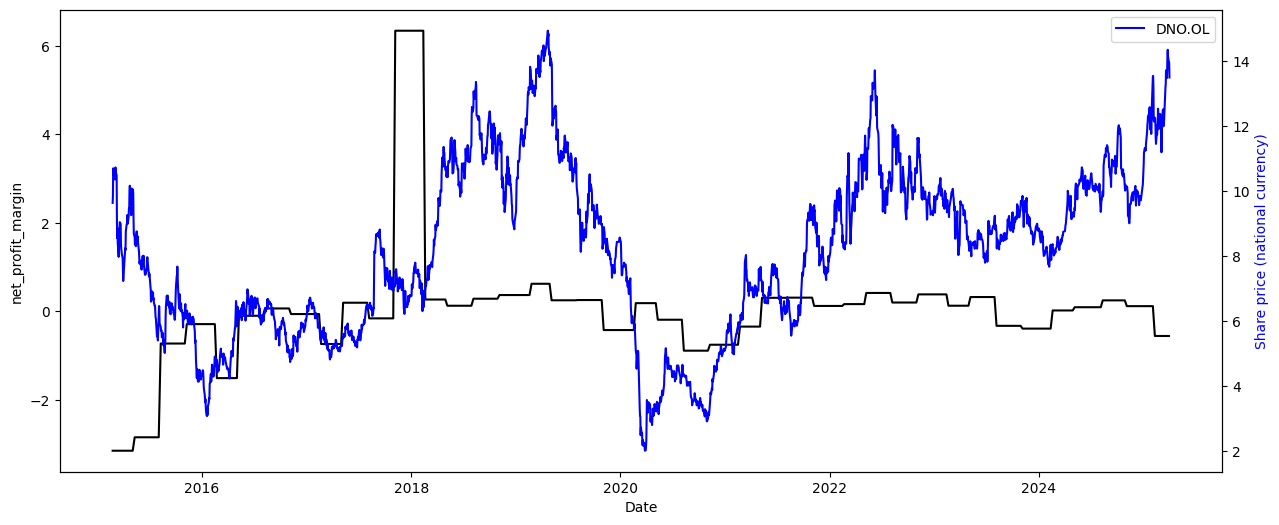

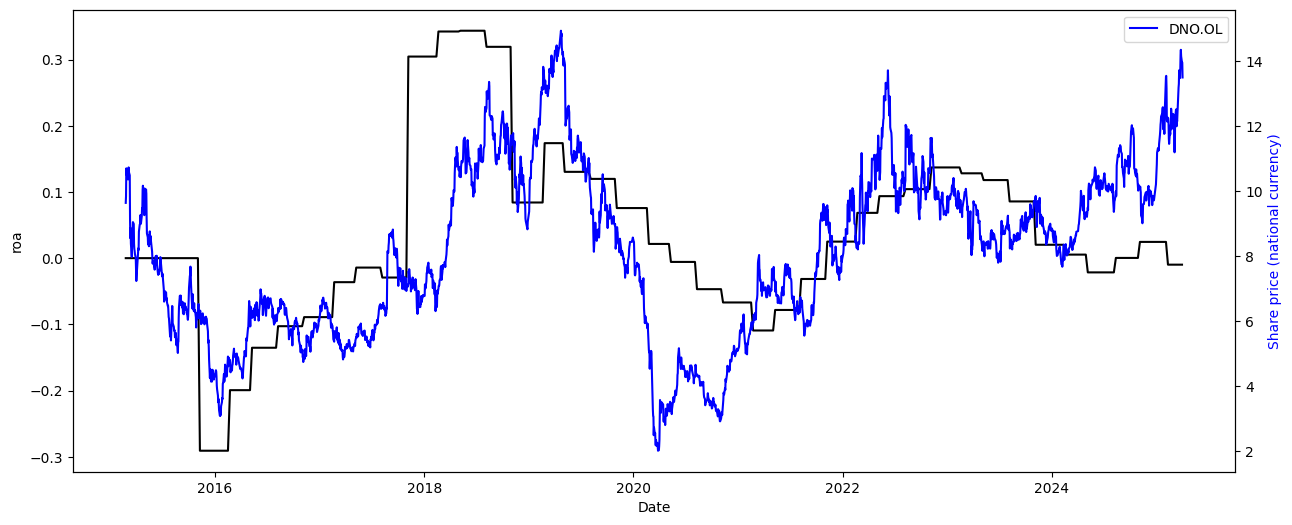

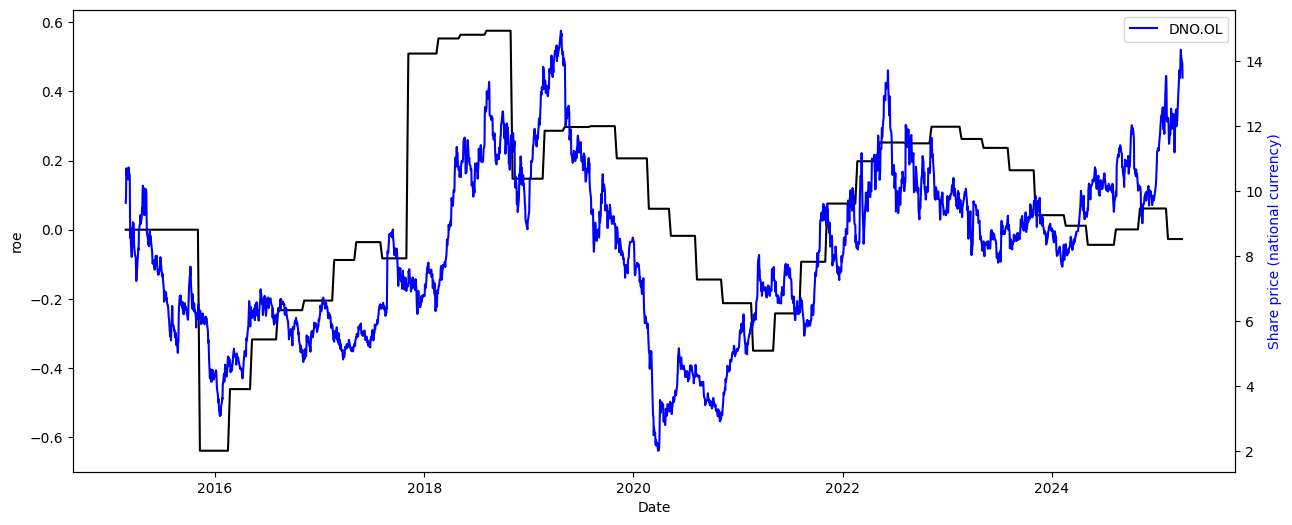

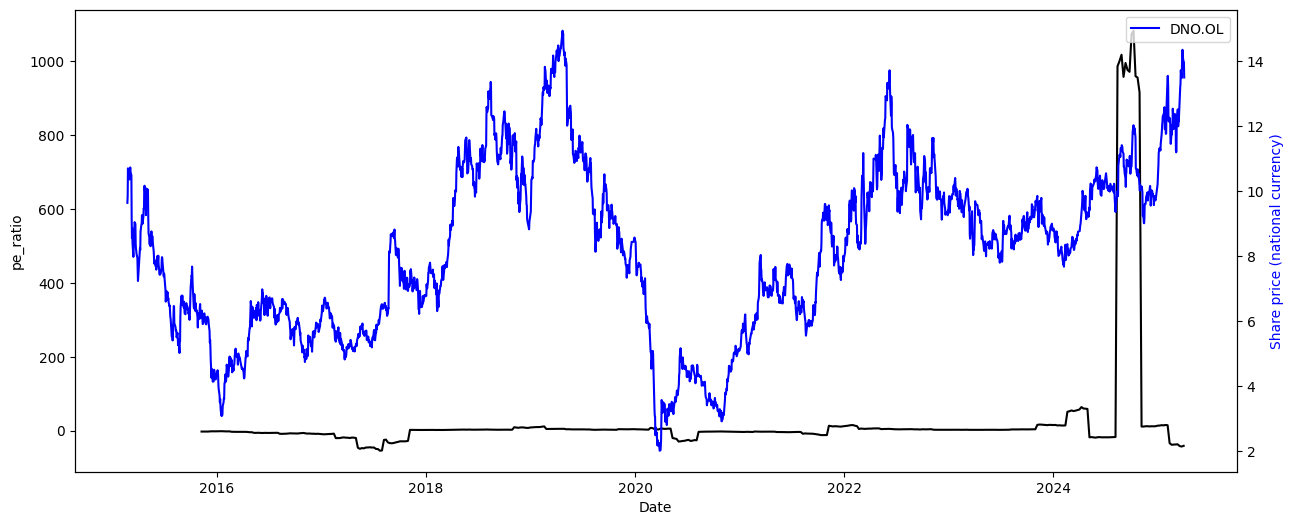

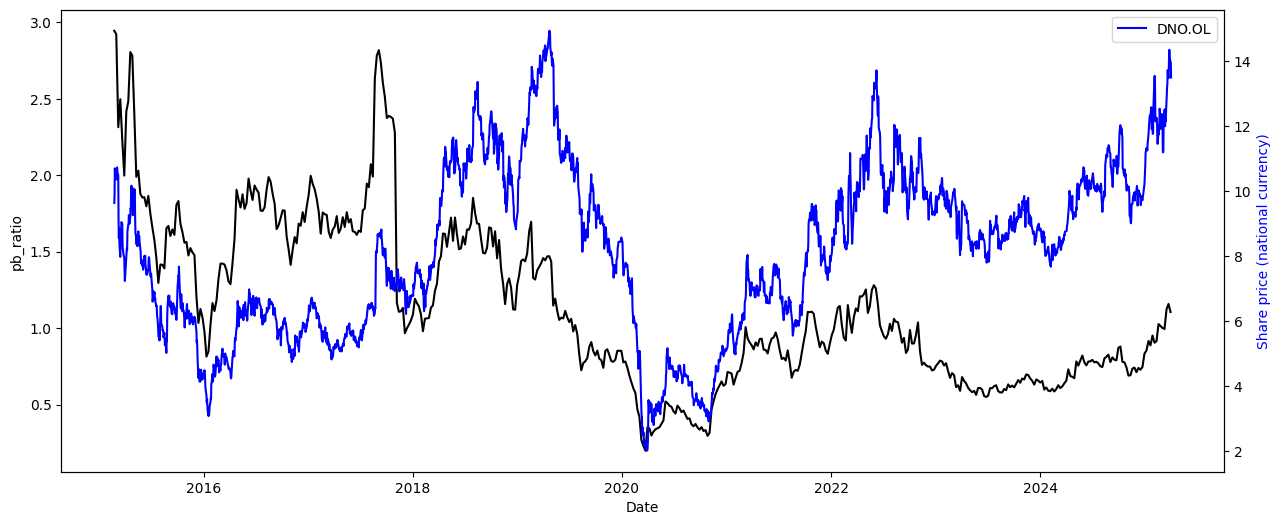

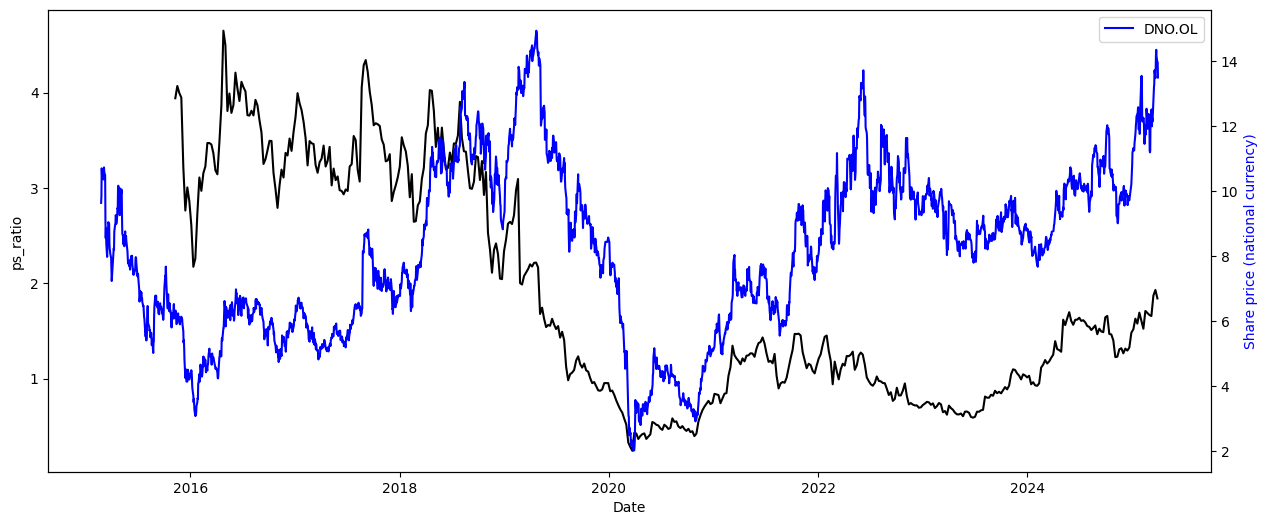

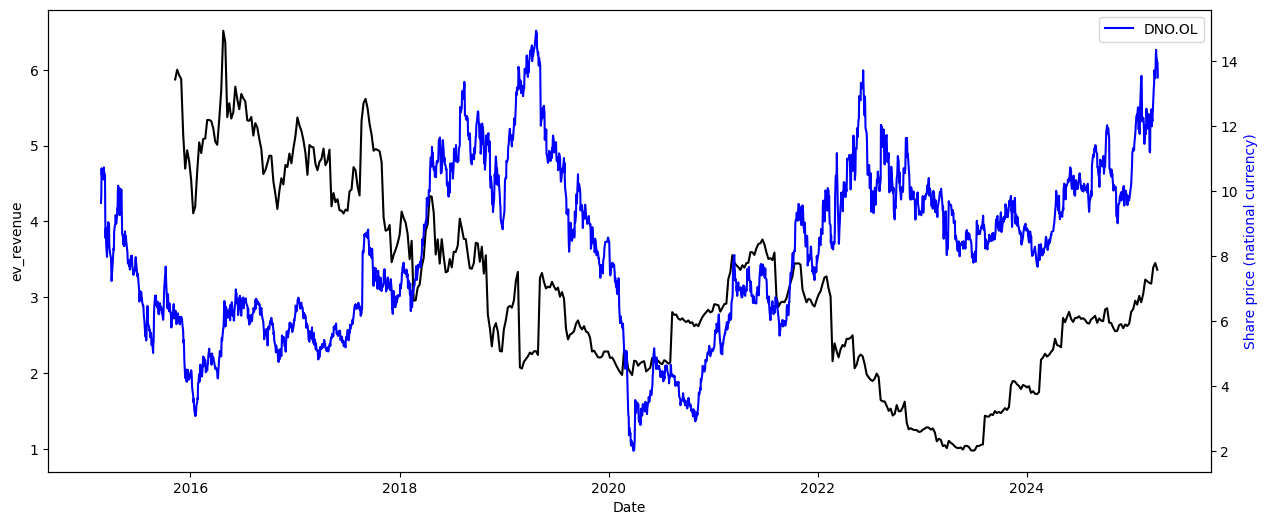

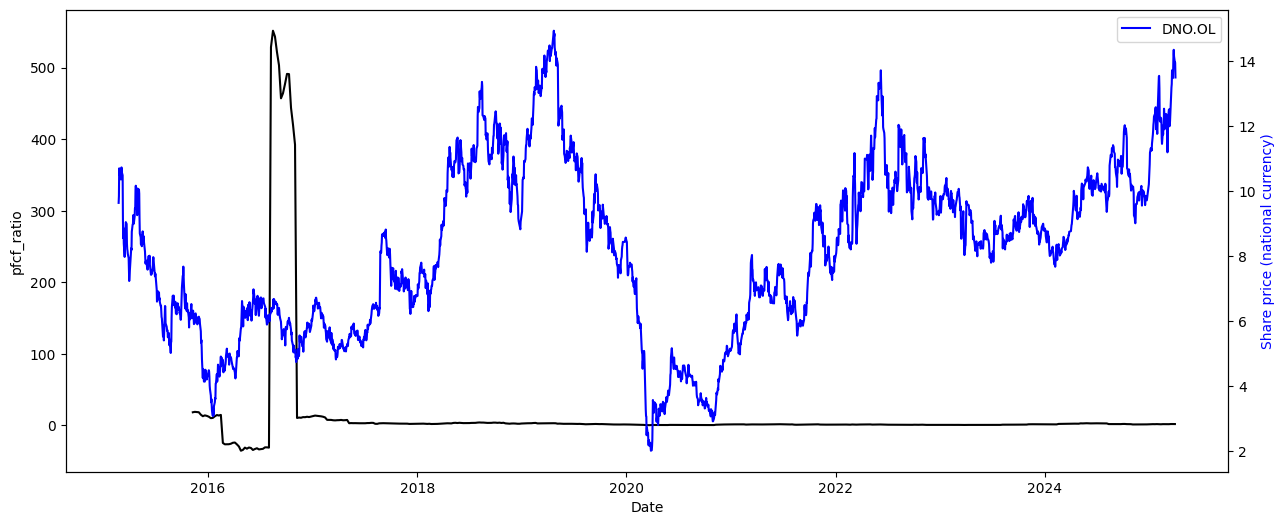

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

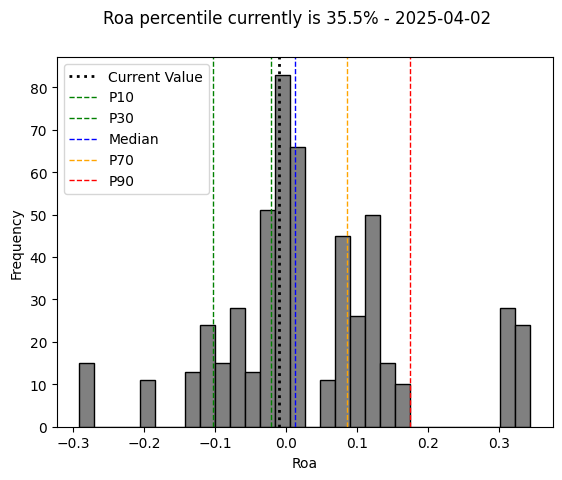

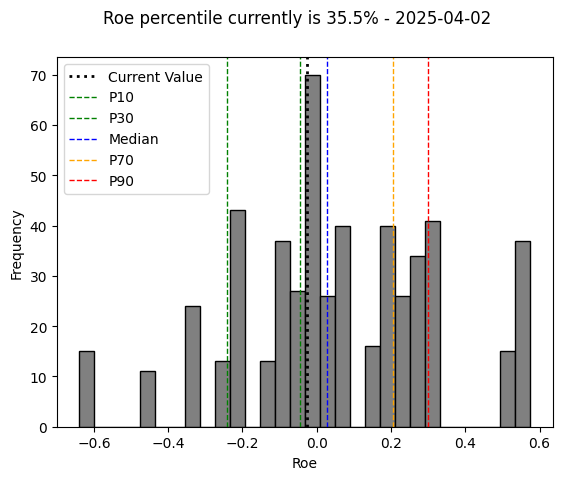

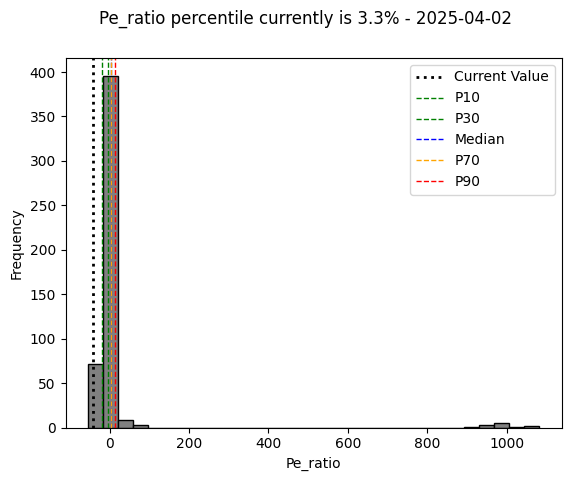

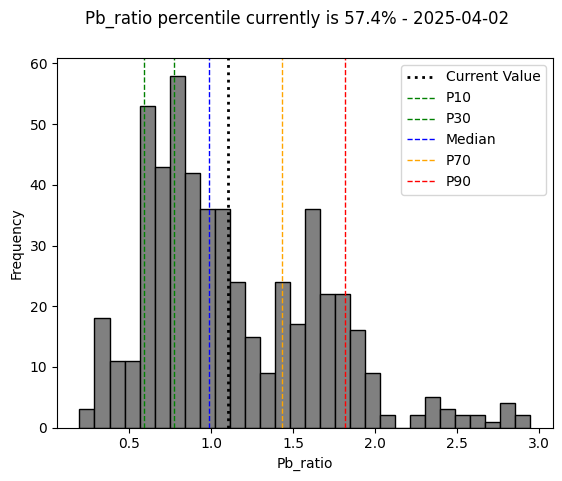

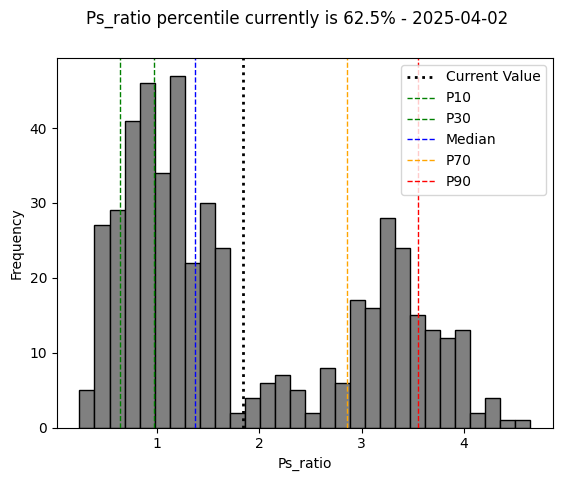

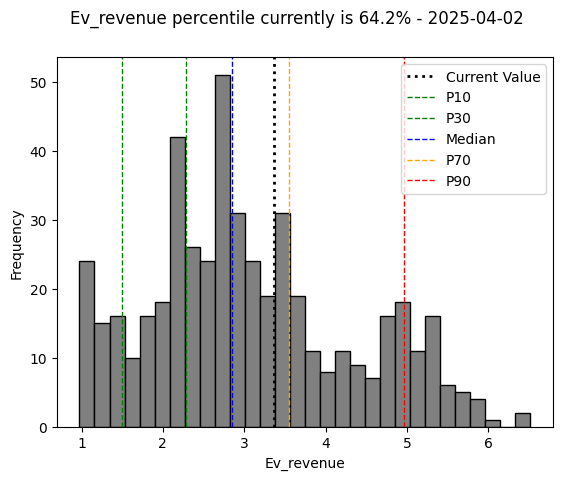

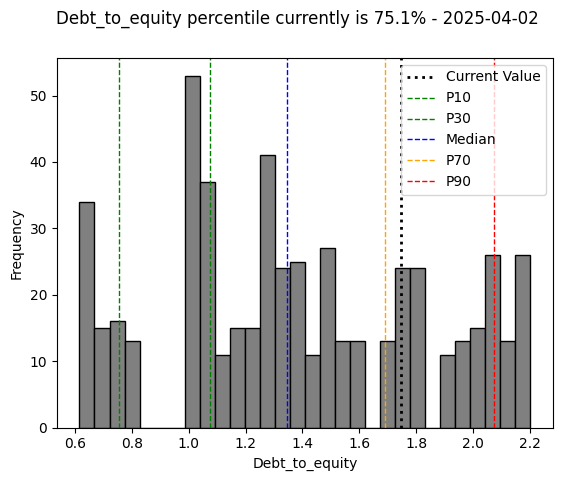

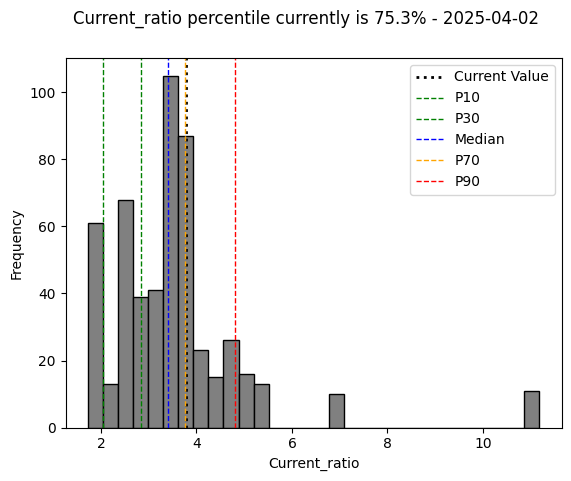

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.982975,-0.018325,-0.056771,-0.040219,-0.414690,-0.513280,0.060113
roe,0.982975,1.000000,-0.005216,-0.092566,-0.128159,-0.496856,-0.474630,0.032734
pe_ratio,-0.018325,-0.005216,1.000000,-0.123772,-0.076001,-0.084445,-0.026272,0.005534
pb_ratio,-0.056771,-0.092566,-0.123772,1.000000,0.901321,0.768486,-0.274921,0.320712
ps_ratio,-0.040219,-0.128159,-0.076001,0.901321,1.000000,0.866748,-0.426778,0.504544
ev_revenue,-0.414690,-0.496856,-0.084445,0.768486,0.866748,1.000000,0.016379,0.348842
debt_to_equity,-0.513280,-0.474630,-0.026272,-0.274921,-0.426778,0.016379,1.000000,-0.250497
current_ratio,0.060113,0.032734,0.005534,0.320712,0.504544,0.348842,-0.250497,1.000000


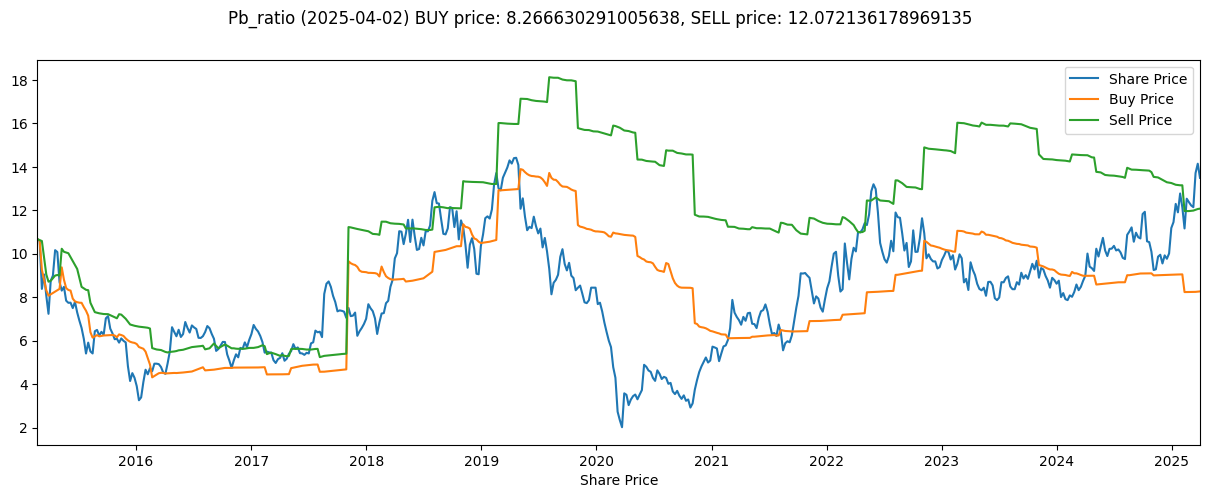

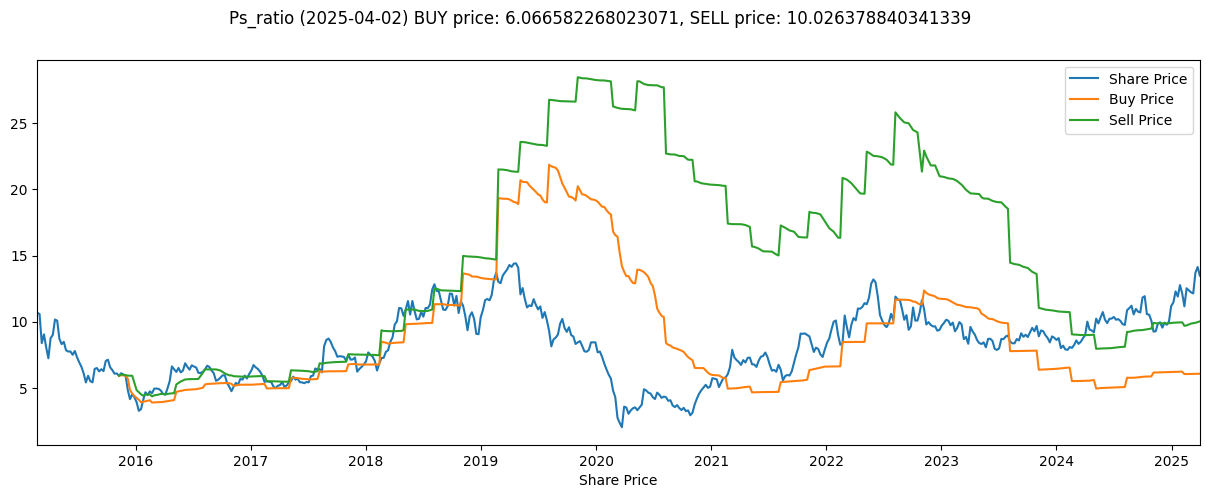

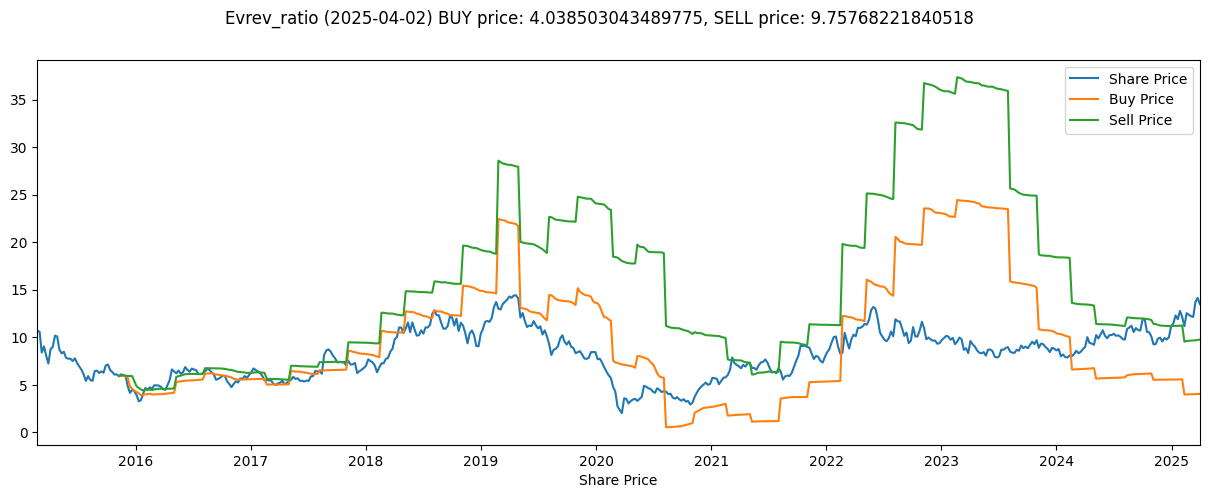

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)